<a href="https://colab.research.google.com/github/Chanthrothayan/Network-Traffic-Classification/blob/main/CNN_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dense, Flatten, AveragePooling1D
from tensorflow.keras.utils import plot_model

# Google Drive mounting if needed
from google.colab import drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    return sum(int(octet) << (8 * i) for i, octet in enumerate(reversed(ip.split('.'))))

def residual_block(x, filters, reduce=False, kernel_size=3):
    stride = 2 if reduce else 1
    y = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=stride)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Conv1D(filters, kernel_size=kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if reduce:
        x = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)

    out = Add()([x, y])
    out = ReLU()(out)
    return out

def build_resnet_1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128, reduce=True)
    x = residual_block(x, 128)
    x = residual_block(x, 256, reduce=True)
    x = residual_block(x, 256)

    x = AveragePooling1D(pool_size=3, strides=2)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Load datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# Preprocessing
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    df['src_mac_addr(eth)'] = df['src_mac_addr(eth)'].apply(mac_to_integer)
    df['dst_mac_addr(eth)'] = df['dst_mac_addr(eth)'].apply(mac_to_integer)
    df['src_ip(arp)'] = df['src_ip(arp)'].apply(ip_to_integer)
    df['dst_ip(arp)'] = df['dst_ip(arp)'].apply(ip_to_integer)

# Feature scaling
scaler = StandardScaler()
features_labeled = df_labeled.drop('Traffic_Label', axis=1)
features_unlabeled = df_unlabeled[features_labeled.columns]
X_labeled = scaler.fit_transform(features_labeled)
X_unlabeled = scaler.transform(features_unlabeled)
y_labeled = df_labeled['Traffic_Label'].values

# Split labeled data
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Model
input_shape = (X_train.shape[1], 1)  # Reshape for 1D convolution
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
model = build_resnet_1d(input_shape, len(np.unique(y_labeled)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predict pseudo-labels for unlabeled data
X_unlabeled = X_unlabeled.reshape((X_unlabeled.shape[0], X_unlabeled.shape[1], 1))
pseudo_labels = model.predict(X_unlabeled).argmax(axis=-1)
print("Pseudo labels:", pseudo_labels)

# Evaluate the model
evaluation = model.evaluate(X_test, y_test, verbose=1)
print("Model evaluation (loss, accuracy):", evaluation)

# Visualize training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Check unique classes in the test labels and predictions
print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in y_pred:", np.unique(y_pred))

# Ensure that the classification report includes all four classes
class_names = ['Benign Traffic', 'ARP Poison', 'ARP Flood']
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

# Plot the confusion matrix with all expected classes
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: could not convert string to float: '00:00:00:00:00:12'

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))


# Load datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# Fill missing values and convert addresses
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    df['src_mac_addr(eth)'] = df['src_mac_addr(eth)'].apply(mac_to_integer)
    df['dst_mac_addr(eth)'] = df['dst_mac_addr(eth)'].apply(mac_to_integer)
    df['src_ip(arp)'] = df['src_ip(arp)'].apply(ip_to_integer)
    df['dst_ip(arp)'] = df['dst_ip(arp)'].apply(ip_to_integer)

# Select only numeric features, excluding the target label column if it's present
features_labeled = df_labeled.drop(columns=['Traffic_Label']).select_dtypes(include=[np.number])
features_unlabeled = df_unlabeled.select_dtypes(include=[np.number])

# Initialize and apply the scaler
scaler = StandardScaler()
X_labeled = scaler.fit_transform(features_labeled)  # Fit and transform on labeled data
X_unlabeled = scaler.transform(features_unlabeled)  # Only transform on unlabeled data

# Get labels if it's a supervised problem
y_labeled = df_labeled['Traffic_Label'].values

# Split the labeled data
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, X_train.shape[2])),
    Dense(len(np.unique(y_labeled)), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# Predict and evaluate
X_unlabeled = X_unlabeled.reshape((X_unlabeled.shape[0], 1, X_unlabeled.shape[1]))
pseudo_labels = model.predict(X_unlabeled).argmax(axis=1)
print("Pseudo labels:", pseudo_labels)

# Evaluation
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_pred = model.predict(X_test_lstm).argmax(axis=-1)
evaluation = model.evaluate(X_test, y_test)
print("Evaluation on test data:", evaluation)

# Visualize training and validation accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Check unique classes in the test labels and predictions
print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in y_pred:", np.unique(y_pred))

# Ensure that the classification report includes all four classes
class_names = ['Benign Traffic', 'ARP Poison', 'ARP Flood']
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)
print("Classification Report:\n", report)

# Plot the confusion matrix with all expected classes
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
670/670 [==============================] - 5s 4ms/step - loss: 0.1321 - accuracy: 0.9773 - val_loss: 0.0138 - val_accuracy: 0.9981
Epoch 2/50
670/670 [==============================] - 2s 3ms/step - loss: 0.0088 - accuracy: 0.9982 - val_loss: 0.0074 - val_accuracy: 0.9983
Epoch 3/50
670/670 [==============================] - 2s 3ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0056 - val_accuracy: 0.9985
Epoch 4/50
670/670 [==============================] - 5s 8ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.0050 - val_accuracy: 0.9983
Epoch 5/50
670/670 [==============================] - 5s 7ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0043 - val_accuracy: 0.9987
Epoch 6/50
670/670 [==============================] - 3s 4ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0040 - val_accuracy: 0.9987
Epoch 7/50
670/670 

ValueError: cannot reshape array of size 87100 into shape (6700,1,1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))



def resnet_block(input_data, filters, conv_size):
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(3, strides=2, padding='same')(x)

    # ResNet blocks
    x = resnet_block(x, 64, 3)
    x = resnet_block(x, 128, 3)
    x = resnet_block(x, 256, 3)
    x = resnet_block(x, 512, 3)

    x = AveragePooling1D(3, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Parameters
input_shape = (X_train.shape[1], 1)  # Reshape for 1D convolution
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
model = build_resnet_1d(input_shape, len(np.unique(y_labeled)))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
num_classes = len(np.unique(y_train))

# Build and compile the model
model = build_resnet(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Predictions and Evaluation
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Ensure test data is reshaped similarly
y_pred = model.predict(X_test_reshaped).argmax(axis=-1)
evaluation = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# Plots and reports similar as before

ValueError: cannot reshape array of size 348400 into shape (26800,1,1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
670/670 [==============================] - 156s 220ms/step - loss: 0.2383 - accuracy: 0.9917 - val_loss: 0.1737 - val_accuracy: 0.9966
Epoch 2/50
670/670 [==============================] - 139s 208ms/step - loss: 0.1426 - accuracy: 0.9951 - val_loss: 0.1076 - val_accuracy: 0.9978
Epoch 3/50
670/670 [==============================] - 140s 209ms/step - loss: 0.0901 - accuracy: 0.9958 - val_loss: 0.0668 - val_accuracy: 0.9976
Epoch 4/50
670/670 [==============================] - 142s 212ms/step - loss: 0.0655 - accuracy: 0.9962 - val_loss: 0.0492 - val_accuracy: 0.9963
Epoch 5/50
670/670 [==============================] - 142s 211ms/step - loss: 0.0622 - accuracy: 0.9959 - val_loss: 0.1905 - val_accuracy: 0.9875
Epoch 6/50
670/670 [==============================] - 140s 209ms/step - loss: 0.0549 - accuracy: 0.9965 - val_loss: 0.0342 - val_accuracy: 0.

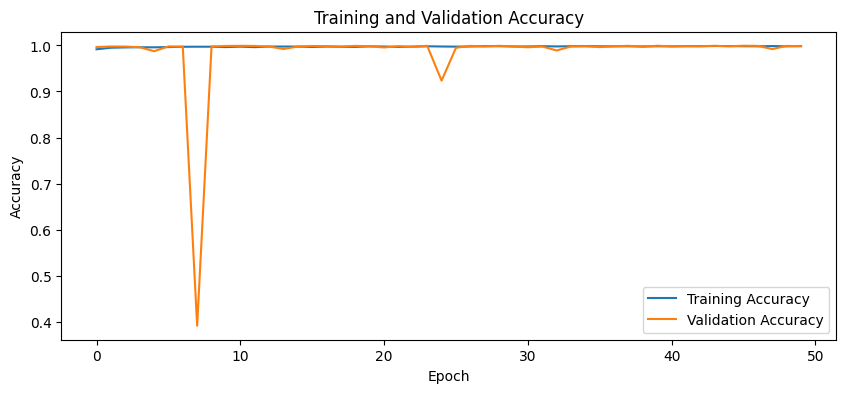

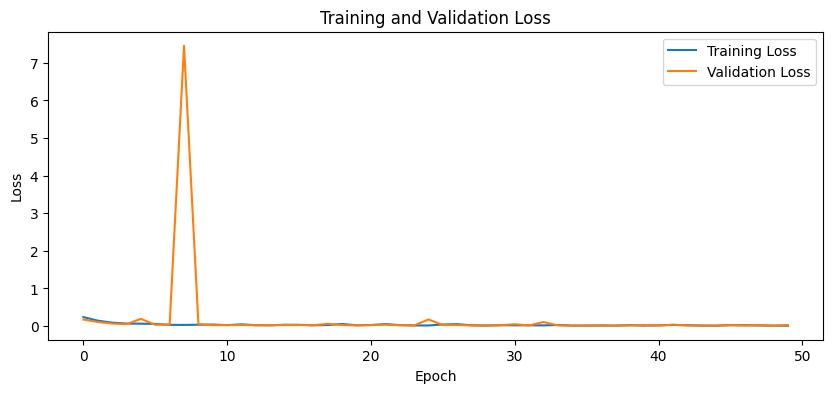

210/210 [==============================] - 4s 15ms/step


NameError: name 'classification_report' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))


# Load datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# Fill missing values and convert addresses
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    df['src_mac_addr(eth)'] = df['src_mac_addr(eth)'].apply(mac_to_integer)
    df['dst_mac_addr(eth)'] = df['dst_mac_addr(eth)'].apply(mac_to_integer)
    df['src_ip(arp)'] = df['src_ip(arp)'].apply(ip_to_integer)
    df['dst_ip(arp)'] = df['dst_ip(arp)'].apply(ip_to_integer)

# Define ResNet block
def resnet_block(input_data, filters, conv_size):
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define ResNet model
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(3, strides=2, padding='same')(x)

    # Add more ResNet blocks
    x = resnet_block(x, 64, 3)
    x = resnet_block(x, 128, 3)
    x = resnet_block(x, 256, 3)
    x = resnet_block(x, 512, 3)

    x = AveragePooling1D(3, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Assume all features except 'Traffic_Label' are used for training
features_labeled = df_labeled.drop('Traffic_Label', axis=1).select_dtypes(include=[np.number])
y_labeled = df_labeled['Traffic_Label'].values
features_unlabeled = df_unlabeled[features_labeled.columns]

# Normalize the features
scaler = StandardScaler()
X_labeled = scaler.fit_transform(features_labeled)
X_unlabeled = scaler.transform(features_unlabeled)

# Split labeled data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Reshape for 1D convolution
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Model configuration
num_classes = len(np.unique(y_train))
model = build_resnet((X_train.shape[1], 1), num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
evaluation = model.evaluate(X_test, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Generate predictions
y_pred = model.predict(X_test).argmax(axis=-1)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_labeled), yticklabels=np.unique(y_labeled))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Ensure that the classification report includes all four classes
class_names = ['Benign Traffic', 'ARP Poison', 'ARP Flood']
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1708
           1       0.98      1.00      0.99       422
           2       1.00      1.00      1.00      4570

    accuracy                           1.00      6700
   macro avg       0.99      1.00      1.00      6700
weighted avg       1.00      1.00      1.00      6700



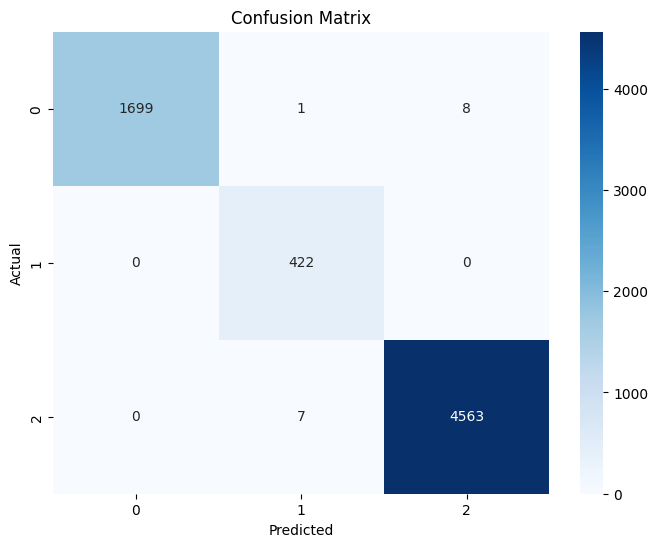

In [ ]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_labeled), yticklabels=np.unique(y_labeled))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

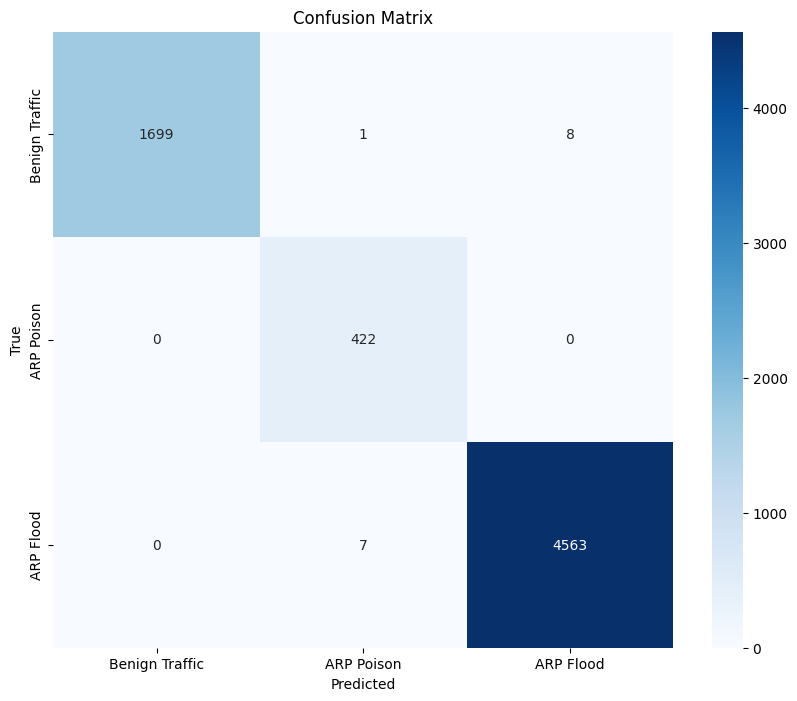

In [ ]:
# Plot the confusion matrix with all expected classes
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))


# Load datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# Fill missing values and convert addresses
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    df['src_mac_addr(eth)'] = df['src_mac_addr(eth)'].apply(mac_to_integer)
    df['dst_mac_addr(eth)'] = df['dst_mac_addr(eth)'].apply(mac_to_integer)
    df['src_ip(arp)'] = df['src_ip(arp)'].apply(ip_to_integer)
    df['dst_ip(arp)'] = df['dst_ip(arp)'].apply(ip_to_integer)

# Define ResNet block
def resnet_block(input_data, filters, conv_size):
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define ResNet model
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(3, strides=2, padding='same')(x)

    # Add more ResNet blocks
    x = resnet_block(x, 64, 3)
    x = resnet_block(x, 128, 3)
    x = resnet_block(x, 256, 3)
    x = resnet_block(x, 512, 3)

    x = AveragePooling1D(3, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Assume all features except 'Traffic_Label' are used for training
features_labeled = df_labeled.drop('Traffic_Label', axis=1).select_dtypes(include=[np.number])
y_labeled = df_labeled['Traffic_Label'].values
features_unlabeled = df_unlabeled[features_labeled.columns]

# Normalize the features
scaler = StandardScaler()
X_labeled = scaler.fit_transform(features_labeled)
X_unlabeled = scaler.transform(features_unlabeled)

# Split labeled data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Reshape for 1D convolution
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Model configuration
num_classes = len(np.unique(y_train))
model = build_resnet((X_train.shape[1], 1), num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
evaluation = model.evaluate(X_test, y_test, verbose=1)
print(f"Model evaluation (loss, accuracy): {evaluation}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ensure that the classification report includes all four classes
class_names = ['Benign Traffic', 'ARP Poison', 'ARP Flood']

report = classification_report(y_test, y_pred, target_names=class_names, zero_division=0)

# Generate predictions
y_pred = model.predict(X_test).argmax(axis=-1)

# Classification report
print(classification_report(y_test, y_pred))


# Plot the confusion matrix with all expected classes
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from google.colab import drive

drive.mount('/content/drive')

def prepare_data():
    df_labeled = pd.read_csv('/content/drive/My Drive/Labelled.csv')
    df_unlabeled = pd.read_csv('/content/drive/My Drive/Unlabelled.csv')
    # Process and prepare your data
    # ...
    return X_train, X_test, y_train, y_test, scaler, df_unlabeled

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(3, strides=2, padding='same')(x)
    x = resnet_block(x, 64, 3)
    x = resnet_block(x, 128, 3)
    x = resnet_block(x, 256, 3)
    x = resnet_block(x, 512, 3)
    x = AveragePooling1D(3, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def resnet_block(input_data, filters, conv_size):
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

X_train, X_test, y_train, y_test, scaler, df_unlabeled = prepare_data()
model = build_resnet((X_train.shape[1], 1), np.unique(y_train).size)

for iteration in range(5):  # You can define the number of iterations
    # Train model
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

    # Evaluate and plot
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test).argmax(axis=-1)
    print(f"Iteration {iteration+1}, Evaluation: {evaluation}")
    print(classification_report(y_test, y_pred))

    # Generate pseudo-labels
    features_unlabeled = scaler.transform(df_unlabeled)
    features_unlabeled = features_unlabeled.reshape((features_unlabeled.shape[0], features_unlabeled.shape[1], 1))
    pseudo_labels = model.predict(features_unlabeled).argmax(axis=-1)

    # Combine pseudo-labeled data with labeled data
    X_train = np.concatenate((X_train, features_unlabeled))
    y_train = np.concatenate((y_train, pseudo_labels))

    # Optional: Plot training and validation accuracy/loss
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    """Convert a MAC address to an integer."""
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    """Convert an IPv4 address to an integer."""
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

def resnet_block(input_data, filters, conv_size):
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(3, strides=2, padding='same')(x)
    x = resnet_block(x, 64, 3)
    x = resnet_block(x, 128, 3)
    x = resnet_block(x, 256, 3)
    x = resnet_block(x, 512, 3)
    x = AveragePooling1D(3, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')

# Preprocess data
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    df['src_mac_addr(eth)'] = df['src_mac_addr(eth)'].apply(mac_to_integer)
    df['dst_mac_addr(eth)'] = df['dst_mac_addr(eth)'].apply(mac_to_integer)
    df['src_ip(arp)'] = df['src_ip(arp)'].apply(ip_to_integer)
    df['dst_ip(arp)'] = df['dst_ip(arp)'].apply(ip_to_integer)

features_labeled = df_labeled.drop('Traffic_Label', axis=1).select_dtypes(include=[np.number])
y_labeled = df_labeled['Traffic_Label'].values
features_unlabeled = df_unlabeled.select_dtypes(include=[np.number])

# Normalize the features
scaler = StandardScaler()
X_labeled = scaler.fit_transform(features_labeled)
X_unlabeled = scaler.transform(features_unlabeled)

# Split labeled data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Model configuration
num_classes = len(np.unique(y_train))
model = build_resnet((X_train.shape[1], 1), num_classes)

# Iterative training
num_iterations = 10  # Number of times to retrain the model with pseudo labels
for iteration in range(num_iterations):
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Generate pseudo-labels
    pseudo_labels = model.predict(X_unlabeled).argmax(axis=-1)

    # Combine datasets
    X_combined = np.concatenate([X_train, X_unlabeled])
    y_combined = np.concatenate([y_train, pseudo_labels])

    # Re-fit the model on the combined dataset
    model.fit(X_combined, y_combined, epochs=10, batch_size=32, validation_split=0.2)

    # Evaluate the model
    evaluation = model.evaluate(X_test, y_test, verbose=1)
    print(f"Iteration {iteration+1}, Model evaluation (loss, accuracy): {evaluation}")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Classification report
    y_pred = model.predict(X_test).argmax(axis=-1)
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
670/670 [==============================] - 167s 238ms/step - loss: 0.2546 - accuracy: 0.9905 - val_loss: 0.1806 - val_accuracy: 0.9959
Epoch 2/10
670/670 [==============================] - 149s 223ms/step - loss: 0.1470 - accuracy: 0.9959 - val_loss: 0.1126 - val_accuracy: 0.9966
Epoch 3/10
670/670 [==============================] - 142s 212ms/step - loss: 0.0925 - accuracy: 0.9965 - val_loss: 0.0723 - val_accuracy: 0.9981
Epoch 4/10
670/670 [==============================] - 143s 214ms/step - loss: 0.0895 - accuracy: 0.9951 - val_loss: 0.0876 - val_accuracy: 0.9946
Epoch 5/10
670/670 [==============================] - 143s 213ms/step - loss: 0.0720 - accuracy: 0.9965 - val_loss: 0.0542 - val_accuracy: 0.9959
Epoch 6/10
670/670 [==============================] - 145s 216ms/step - loss: 0.0426 - accuracy: 0.9969 - val_loss: 0.0322 - val_accuracy: 0.

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
# Reshape unlabeled features for consistency with the CNN input
X_unlabeled = X_unlabeled.reshape((X_unlabeled.shape[0], X_unlabeled.shape[1], 1))

# Now you can concatenate them safely
X_combined = np.concatenate([X_train, X_unlabeled])
y_combined = np.concatenate([y_train, pseudo_labels])

Epoch 1/10
3183/3183 [==============================] - 691s 216ms/step - loss: 0.0327 - accuracy: 0.9968 - val_loss: 0.0719 - val_accuracy: 0.9952
Epoch 2/10
3183/3183 [==============================] - 680s 213ms/step - loss: 0.0304 - accuracy: 0.9971 - val_loss: 0.0556 - val_accuracy: 0.9957
Epoch 3/10
3183/3183 [==============================] - 687s 216ms/step - loss: 0.0220 - accuracy: 0.9972 - val_loss: 0.0245 - val_accuracy: 0.9980
Epoch 4/10
3183/3183 [==============================] - 678s 213ms/step - loss: 0.0226 - accuracy: 0.9975 - val_loss: 0.0130 - val_accuracy: 0.9980
Epoch 5/10
3183/3183 [==============================] - 688s 216ms/step - loss: 0.0188 - accuracy: 0.9977 - val_loss: 0.1689 - val_accuracy: 0.9938
Epoch 6/10
3183/3183 [==============================] - 691s 217ms/step - loss: 0.0233 - accuracy: 0.9977 - val_loss: 0.0258 - val_accuracy: 0.9977
Epoch 7/10
3183/3183 [==============================] - 676s 212ms/step - loss: 0.0174 - accuracy: 0.9979 - val_

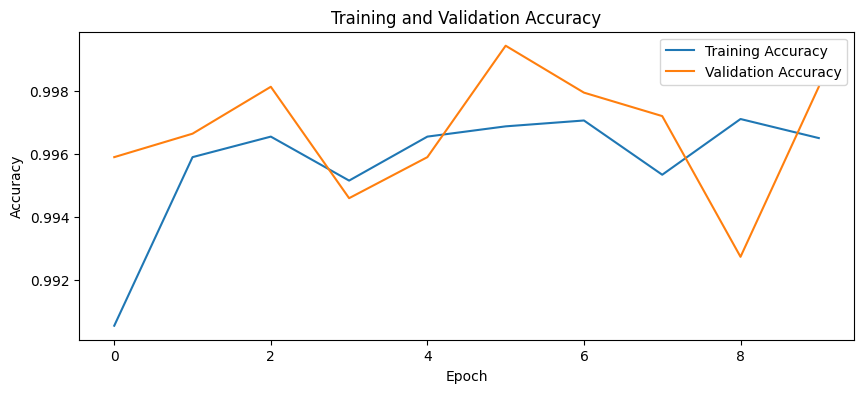

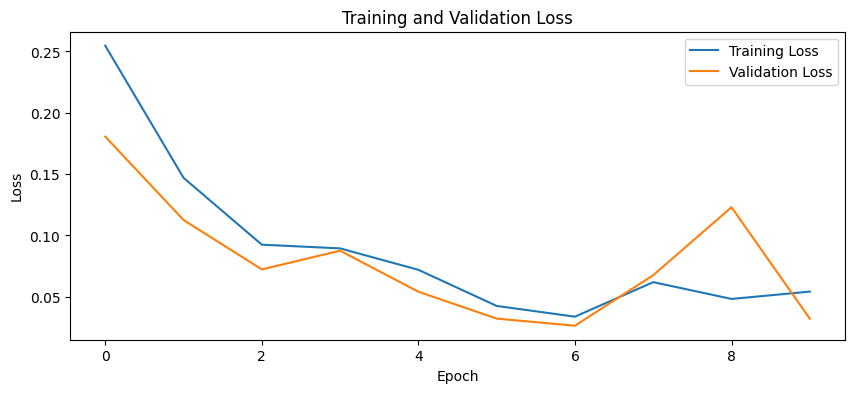

210/210 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1708
           1       0.99      0.98      0.98       422
           2       1.00      1.00      1.00      4570

    accuracy                           1.00      6700
   macro avg       0.99      0.99      0.99      6700
weighted avg       1.00      1.00      1.00      6700



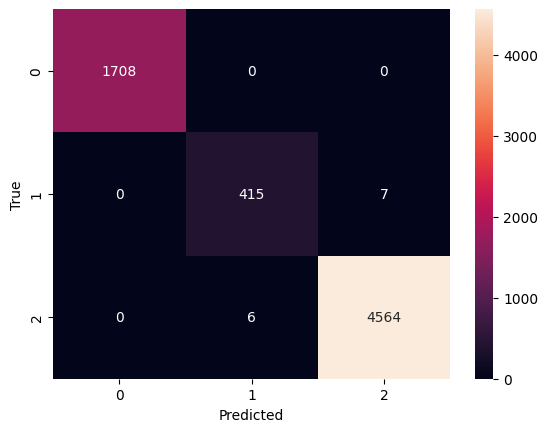

In [ ]:

    # Re-fit the model on the combined dataset
    model.fit(X_combined, y_combined, epochs=10, batch_size=32, validation_split=0.2)

    # Evaluate the model
    evaluation = model.evaluate(X_test, y_test, verbose=1)
    print(f"Iteration {iteration+1}, Model evaluation (loss, accuracy): {evaluation}")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Classification report
    y_pred = model.predict(X_test).argmax(axis=-1)
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Mounted at /content/drive
Epoch 1/10
670/670 [==============================] - 128s 182ms/step - loss: 0.2412 - accuracy: 0.9918 - val_loss: 0.1785 - val_accuracy: 0.9972
Epoch 2/10
670/670 [==============================] - 119s 178ms/step - loss: 0.1530 - accuracy: 0.9951 - val_loss: 0.1144 - val_accuracy: 0.9976
Epoch 3/10
670/670 [==============================] - 120s 179ms/step - loss: 0.0948 - accuracy: 0.9964 - val_loss: 0.0695 - val_accuracy: 0.9989
Epoch 4/10
670/670 [==============================] - 120s 179ms/step - loss: 0.0621 - accuracy: 0.9964 - val_loss: 0.0478 - val_accuracy: 0.9985
Epoch 5/10
670/670 [==============================] - 118s 175ms/step - loss: 0.0438 - accuracy: 0.9968 - val_loss: 0.0335 - val_accuracy: 0.9989
Epoch 6/10
670/670 [==============================] - 119s 177ms/step - loss: 0.0626 - accuracy: 0.9954 - val_loss: 0.0524 - val_accuracy: 0.9987
Epoch 7/10
670/670 [==============================] - 122s 183ms/step - loss: 0.0372 - accuracy: 0

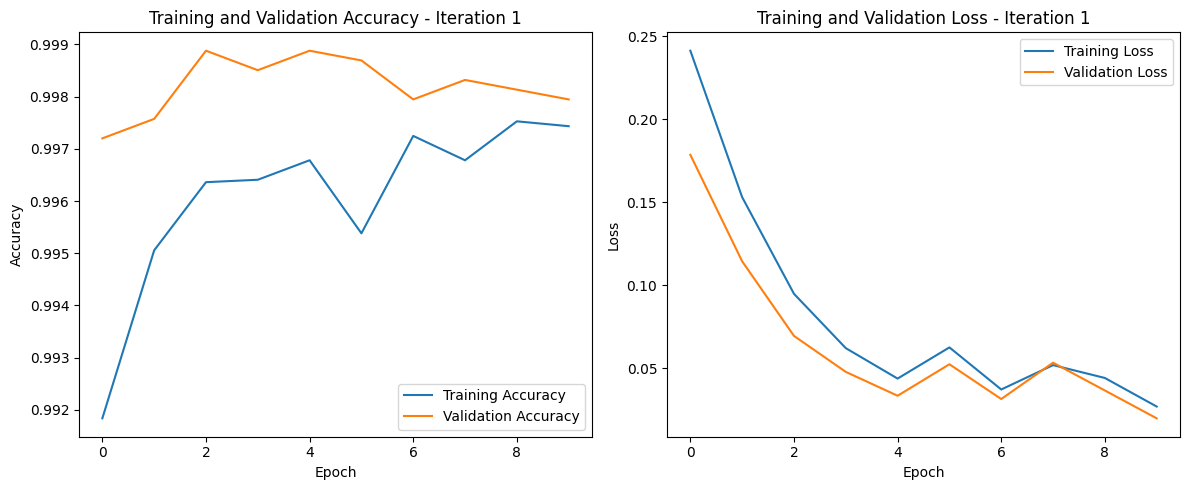

3141/3141 [==============================] - 47s 15ms/step
Epoch 1/10
3183/3183 [==============================] - 586s 183ms/step - loss: 0.0250 - accuracy: 0.9974 - val_loss: 0.1770 - val_accuracy: 0.9812
Epoch 2/10
3183/3183 [==============================] - 575s 181ms/step - loss: 0.0352 - accuracy: 0.9977 - val_loss: 0.0173 - val_accuracy: 0.9989
Epoch 3/10
3183/3183 [==============================] - 601s 189ms/step - loss: 0.0265 - accuracy: 0.9977 - val_loss: 0.0142 - val_accuracy: 0.9995
Epoch 4/10
3183/3183 [==============================] - 589s 185ms/step - loss: 0.0358 - accuracy: 0.9977 - val_loss: 0.0135 - val_accuracy: 0.9998
Epoch 5/10
3183/3183 [==============================] - 574s 180ms/step - loss: 0.0214 - accuracy: 0.9981 - val_loss: 0.0108 - val_accuracy: 0.9989
Epoch 6/10
3183/3183 [==============================] - 589s 185ms/step - loss: 0.0225 - accuracy: 0.9979 - val_loss: 0.6822 - val_accuracy: 0.9709
Epoch 7/10
3183/3183 [==============================]

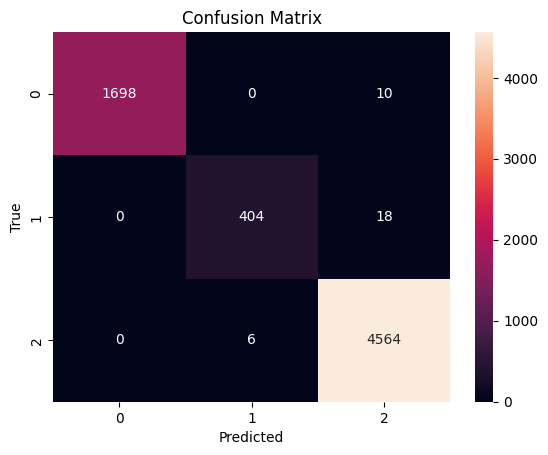

Epoch 1/10
670/670 [==============================] - 119s 178ms/step - loss: 0.0202 - accuracy: 0.9978 - val_loss: 0.0536 - val_accuracy: 0.9901
Epoch 2/10
670/670 [==============================] - 120s 180ms/step - loss: 0.0162 - accuracy: 0.9981 - val_loss: 0.0101 - val_accuracy: 0.9996
Epoch 3/10
670/670 [==============================] - 123s 184ms/step - loss: 0.0100 - accuracy: 0.9986 - val_loss: 0.0081 - val_accuracy: 0.9993
Epoch 4/10
670/670 [==============================] - 123s 184ms/step - loss: 0.0095 - accuracy: 0.9982 - val_loss: 0.0102 - val_accuracy: 0.9989
Epoch 5/10
670/670 [==============================] - 125s 186ms/step - loss: 0.0090 - accuracy: 0.9984 - val_loss: 0.0210 - val_accuracy: 0.9979
Epoch 6/10
670/670 [==============================] - 120s 179ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 0.0138 - val_accuracy: 0.9970
Epoch 7/10
670/670 [==============================] - 120s 179ms/step - loss: 0.0169 - accuracy: 0.9984 - val_loss: 0.0204 -

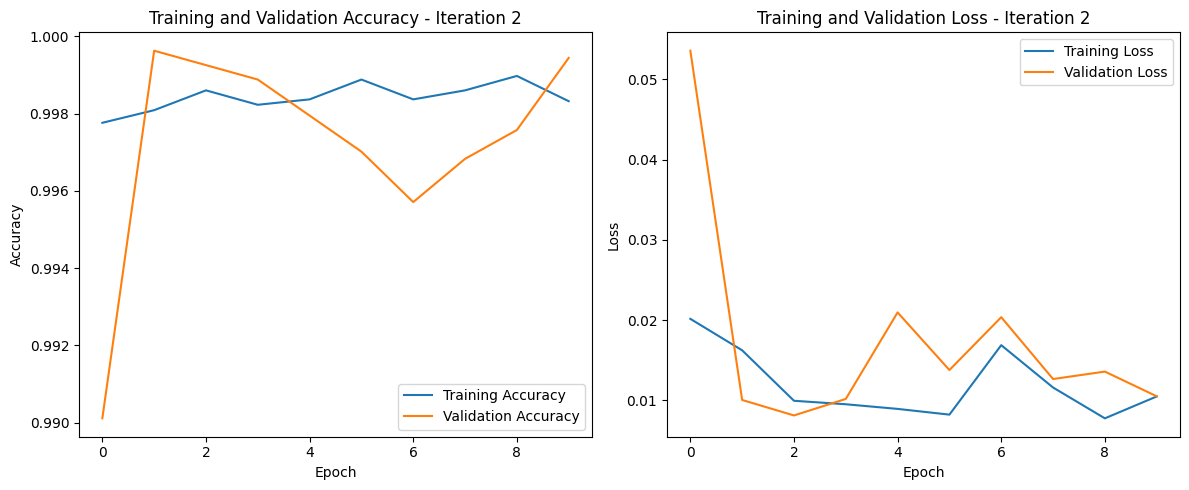

3141/3141 [==============================] - 49s 16ms/step
Epoch 1/10
3183/3183 [==============================] - 570s 179ms/step - loss: 0.0105 - accuracy: 0.9988 - val_loss: 0.0085 - val_accuracy: 0.9993
Epoch 2/10
3183/3183 [==============================] - 570s 179ms/step - loss: 0.0074 - accuracy: 0.9988 - val_loss: 0.0059 - val_accuracy: 0.9999
Epoch 3/10
3183/3183 [==============================] - 584s 183ms/step - loss: 0.0087 - accuracy: 0.9988 - val_loss: 0.0061 - val_accuracy: 0.9998
Epoch 4/10
3183/3183 [==============================] - 578s 182ms/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 0.0046 - val_accuracy: 0.9998
Epoch 5/10
3183/3183 [==============================] - 580s 182ms/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.0050 - val_accuracy: 0.9997
Epoch 6/10
3183/3183 [==============================] - 576s 181ms/step - loss: 0.0063 - accuracy: 0.9990 - val_loss: 0.0043 - val_accuracy: 0.9995
Epoch 7/10
3183/3183 [==============================]

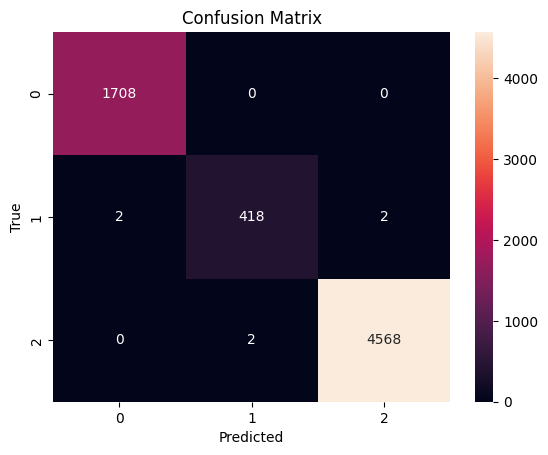

Epoch 1/10
670/670 [==============================] - 119s 178ms/step - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0041 - val_accuracy: 0.9994
Epoch 2/10
670/670 [==============================] - 121s 181ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.0209 - val_accuracy: 0.9959
Epoch 3/10
670/670 [==============================] - 123s 184ms/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.0066 - val_accuracy: 0.9985
Epoch 4/10
670/670 [==============================] - 118s 176ms/step - loss: 0.0059 - accuracy: 0.9989 - val_loss: 0.0058 - val_accuracy: 0.9993
Epoch 5/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0047 - accuracy: 0.9991 - val_loss: 0.0067 - val_accuracy: 0.9985
Epoch 6/10
670/670 [==============================] - 120s 180ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.0061 - val_accuracy: 0.9991
Epoch 7/10
670/670 [==============================] - 121s 181ms/step - loss: 0.0051 - accuracy: 0.9991 - val_loss: 0.0110 -

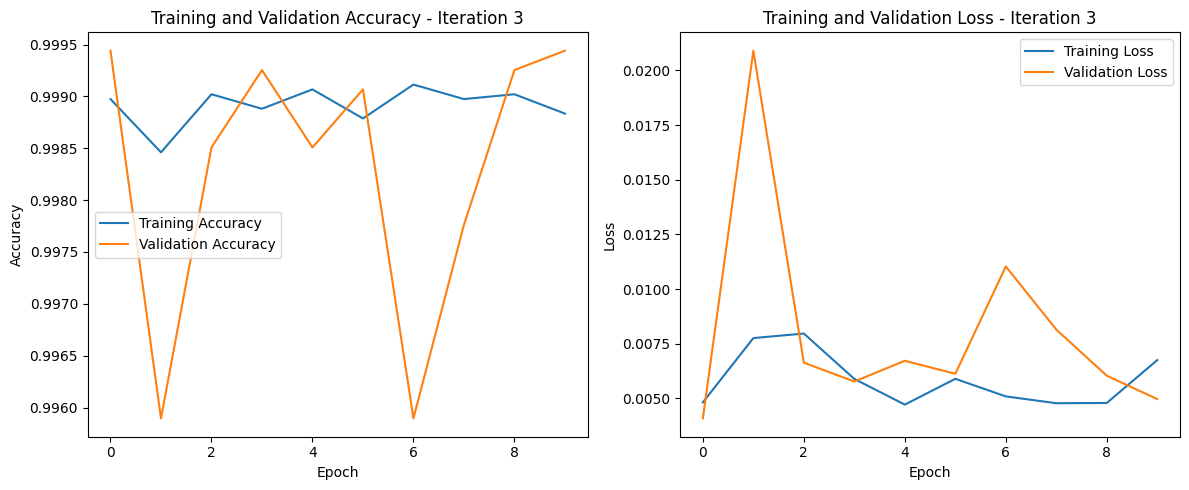

3141/3141 [==============================] - 51s 16ms/step
Epoch 1/10
3183/3183 [==============================] - 590s 185ms/step - loss: 0.0043 - accuracy: 0.9992 - val_loss: 0.0437 - val_accuracy: 0.9836
Epoch 2/10
3183/3183 [==============================] - 576s 181ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9999
Epoch 3/10
3183/3183 [==============================] - 580s 182ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0032 - val_accuracy: 0.9999
Epoch 4/10
3183/3183 [==============================] - 575s 181ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0053 - val_accuracy: 0.9993
Epoch 5/10
3183/3183 [==============================] - 590s 185ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0039 - val_accuracy: 0.9996
Epoch 6/10
3183/3183 [==============================] - 586s 184ms/step - loss: 0.0050 - accuracy: 0.9992 - val_loss: 0.0197 - val_accuracy: 0.9924
Epoch 7/10
3183/3183 [==============================]

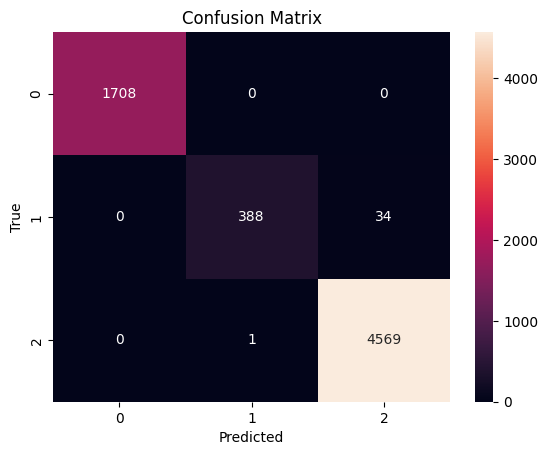

Epoch 1/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9996
Epoch 2/10
670/670 [==============================] - 120s 180ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9994
Epoch 3/10
670/670 [==============================] - 122s 181ms/step - loss: 0.0041 - accuracy: 0.9991 - val_loss: 0.0040 - val_accuracy: 0.9996
Epoch 4/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 0.0242 - val_accuracy: 0.9897
Epoch 5/10
670/670 [==============================] - 125s 187ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.0166 - val_accuracy: 0.9925
Epoch 6/10
670/670 [==============================] - 121s 181ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.0051 - val_accuracy: 0.9985
Epoch 7/10
670/670 [==============================] - 123s 183ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0042 -

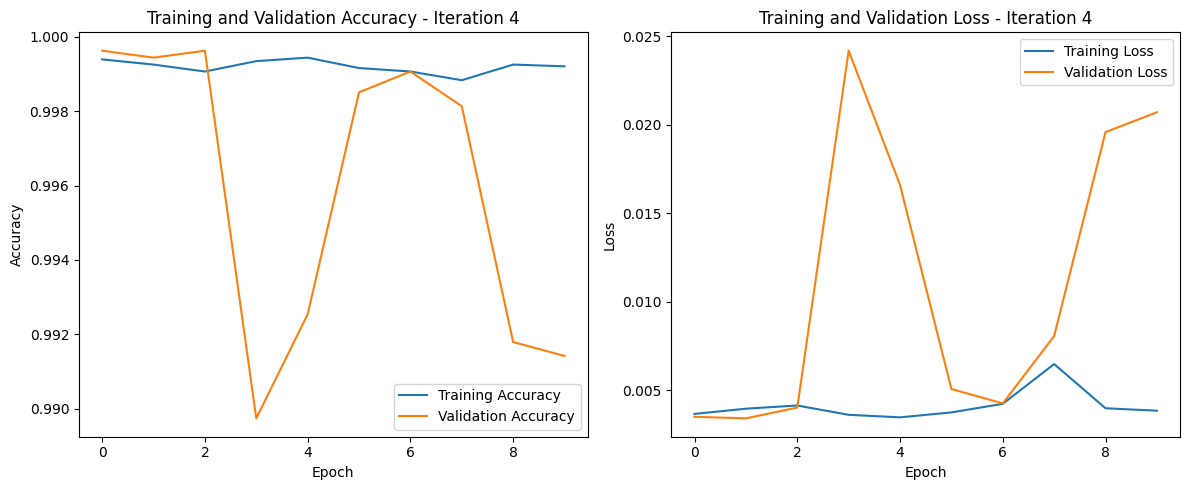

3141/3141 [==============================] - 54s 17ms/step
Epoch 1/10
3183/3183 [==============================] - 592s 186ms/step - loss: 0.0080 - accuracy: 0.9971 - val_loss: 0.0033 - val_accuracy: 0.9991
Epoch 2/10
3183/3183 [==============================] - 588s 185ms/step - loss: 0.0071 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 0.9995
Epoch 3/10
3183/3183 [==============================] - 583s 183ms/step - loss: 0.0081 - accuracy: 0.9972 - val_loss: 0.0097 - val_accuracy: 0.9934
Epoch 4/10
3183/3183 [==============================] - 589s 185ms/step - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.0046 - val_accuracy: 0.9996
Epoch 5/10
3183/3183 [==============================] - 588s 185ms/step - loss: 0.0070 - accuracy: 0.9973 - val_loss: 0.0043 - val_accuracy: 0.9989
Epoch 6/10
3183/3183 [==============================] - 595s 187ms/step - loss: 0.0069 - accuracy: 0.9975 - val_loss: 0.0028 - val_accuracy: 0.9995
Epoch 7/10
3183/3183 [==============================]

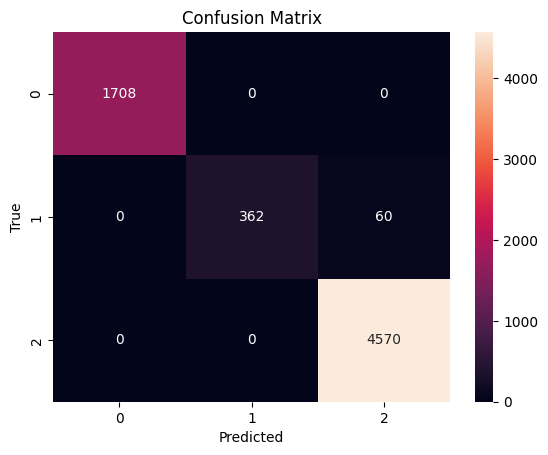

Epoch 1/10
670/670 [==============================] - 125s 186ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 2/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 3/10
670/670 [==============================] - 120s 180ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0161 - val_accuracy: 0.9916
Epoch 4/10
670/670 [==============================] - 120s 179ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.0055 - val_accuracy: 0.9996
Epoch 5/10
670/670 [==============================] - 122s 183ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0036 - val_accuracy: 0.9996
Epoch 6/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 7/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0032 -

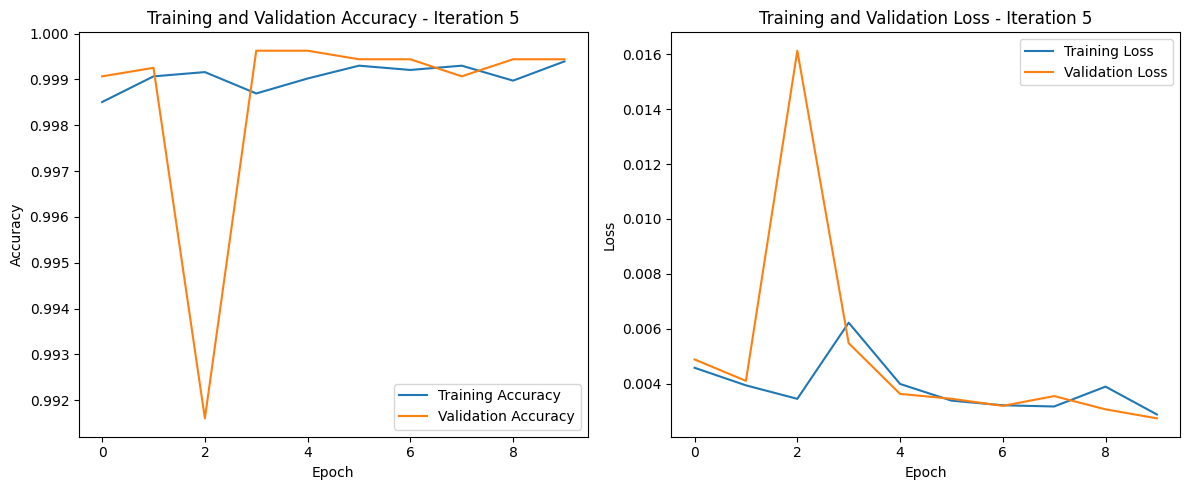

3141/3141 [==============================] - 52s 17ms/step
Epoch 1/10
3183/3183 [==============================] - 596s 187ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 2/10
3183/3183 [==============================] - 589s 185ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 3/10
3183/3183 [==============================] - 580s 182ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/10
3183/3183 [==============================] - 574s 180ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0051 - val_accuracy: 0.9984
Epoch 5/10
3183/3183 [==============================] - 569s 179ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0074 - val_accuracy: 0.9973
Epoch 6/10
3183/3183 [==============================] - 570s 179ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0116 - val_accuracy: 0.9948
Epoch 7/10
3183/3183 [==============================]

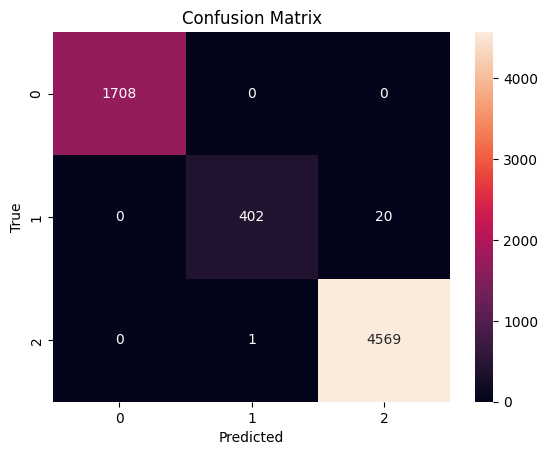

Epoch 1/10
670/670 [==============================] - 121s 180ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9998
Epoch 2/10
670/670 [==============================] - 123s 184ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 3/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0079 - val_accuracy: 0.9972
Epoch 4/10
670/670 [==============================] - 126s 188ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0097 - val_accuracy: 0.9951
Epoch 5/10
670/670 [==============================] - 124s 184ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0040 - val_accuracy: 0.9996
Epoch 6/10
670/670 [==============================] - 121s 181ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9998
Epoch 7/10
670/670 [==============================] - 123s 183ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0052 -

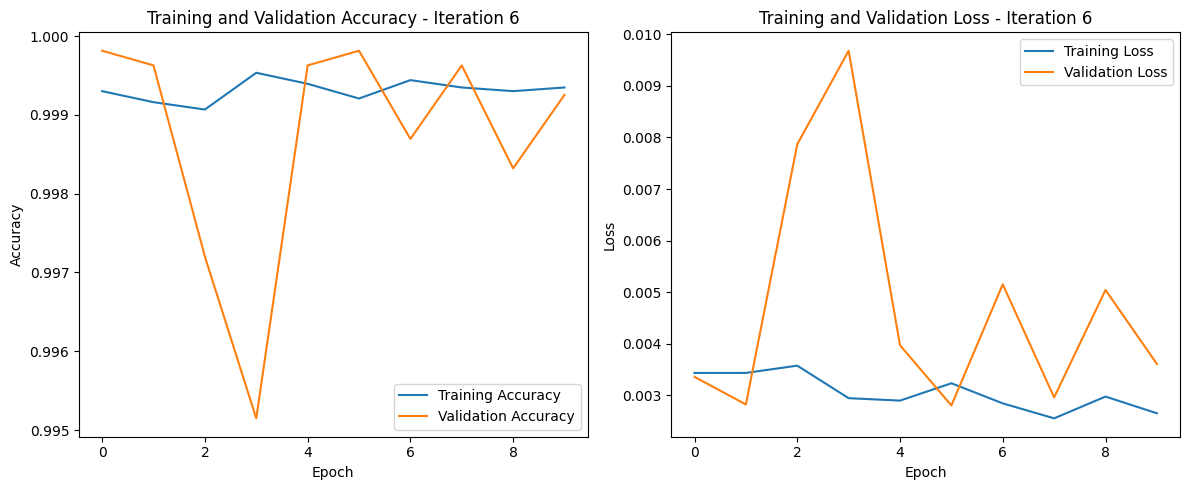

3141/3141 [==============================] - 51s 16ms/step
Epoch 1/10
3183/3183 [==============================] - 584s 183ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 2/10
3183/3183 [==============================] - 598s 188ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 3/10
3183/3183 [==============================] - 592s 186ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 4/10
3183/3183 [==============================] - 586s 184ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9997
Epoch 5/10
3183/3183 [==============================] - 593s 186ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 6/10
3183/3183 [==============================] - 598s 188ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 0.0076 - val_accuracy: 0.9962
Epoch 7/10
3183/3183 [==============================]

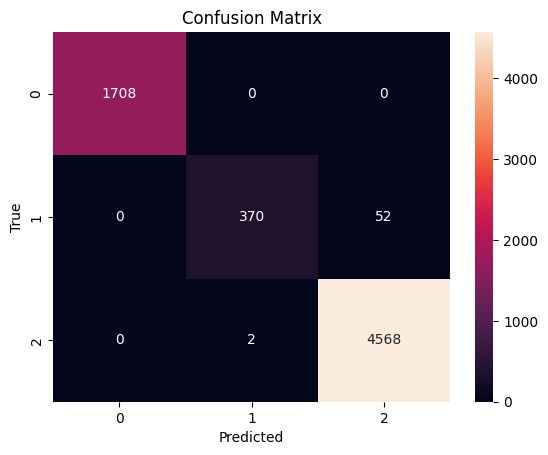

Epoch 1/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 0.9998
Epoch 2/10
670/670 [==============================] - 125s 187ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0061 - val_accuracy: 0.9985
Epoch 3/10
670/670 [==============================] - 123s 184ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0112 - val_accuracy: 0.9938
Epoch 4/10
670/670 [==============================] - 123s 183ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 5/10
670/670 [==============================] - 122s 182ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9996
Epoch 6/10
670/670 [==============================] - 123s 184ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0083 - val_accuracy: 0.9987
Epoch 7/10
670/670 [==============================] - 124s 185ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0049 -

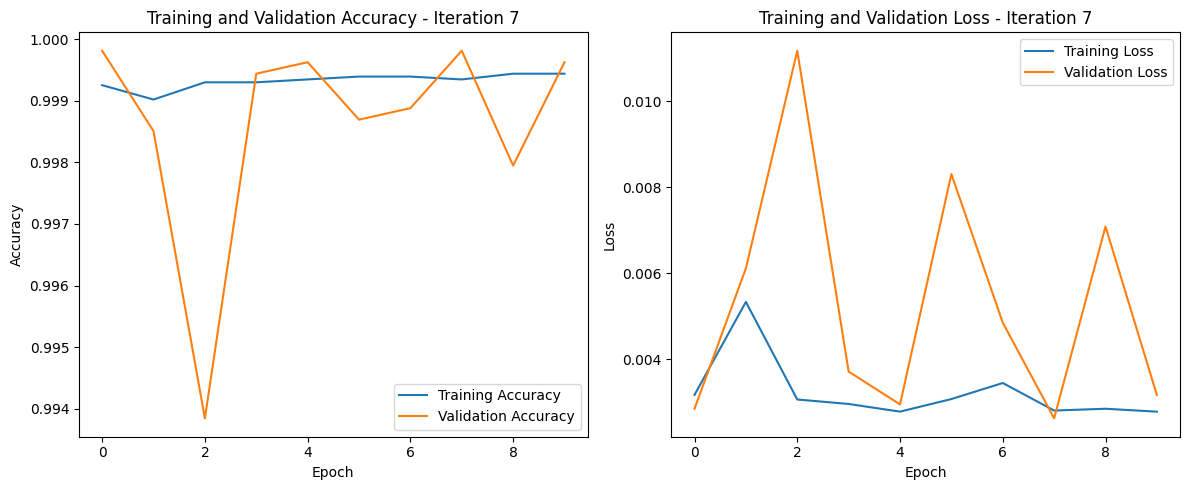

3141/3141 [==============================] - 55s 17ms/step
Epoch 1/10
3183/3183 [==============================] - 591s 186ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0088 - val_accuracy: 0.9947
Epoch 2/10
3183/3183 [==============================] - 597s 188ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 0.9998
Epoch 3/10
 947/3183 [=======>......................] - ETA: 6:51 - loss: 0.0027 - accuracy: 0.9994

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, AveragePooling1D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def mac_to_integer(mac):
    return -1 if mac == 'missing' else int(mac.replace(":", ""), 16)

def ip_to_integer(ip):
    octets = map(int, ip.split('.'))
    return sum(octet << (8 * index) for index, octet in enumerate(reversed(list(octets))))

def resnet_block(input_data, filters, conv_size):
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, conv_size, padding='same', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(1e-4))(input_data)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 7, padding='same', strides=2, kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling1D(3, strides=2, padding='same')(x)
    x = resnet_block(x, 64, 3)
    x = resnet_block(x, 128, 3)
    x = resnet_block(x, 256, 3)
    x = resnet_block(x, 512, 3)
    x = AveragePooling1D(3, padding='same')(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Load and preprocess datasets
df_labeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Labelled/New/Labelled_ARP Poison,flood attack Dataset.csv')
df_unlabeled = pd.read_csv('/content/drive/Othercomputers/My laptop/Datasets/to be use/Unlabelled/Unlabelled_ARP Poison,flood attack Dataset.csv')
for df in [df_labeled, df_unlabeled]:
    df.fillna('missing', inplace=True)
    df['src_mac_addr(eth)'] = df['src_mac_addr(eth)'].apply(mac_to_integer)
    df['dst_mac_addr(eth)'] = df['dst_mac_addr(eth)'].apply(mac_to_integer)
    df['src_ip(arp)'] = df['src_ip(arp)'].apply(ip_to_integer)
    df['dst_ip(arp)'] = df['dst_ip(arp)'].apply(ip_to_integer)

features_labeled = df_labeled.drop('Traffic_Label', axis=1).select_dtypes(include=[np.number])
features_unlabeled = df_unlabeled.select_dtypes(include=[np.number])
y_labeled = df_labeled['Traffic_Label'].values

# Normalize the features
scaler = StandardScaler()
X_labeled = scaler.fit_transform(features_labeled)
X_unlabeled = scaler.transform(features_unlabeled)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Reshape features for CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_unlabeled = X_unlabeled.reshape((X_unlabeled.shape[0], X_unlabeled.shape[1], 1))

# Model configuration and training
num_classes = len(np.unique(y_train))
model = build_resnet((X_train.shape[1], 1), num_classes)
for iteration in range(7):  # Number of times to retrain the model with pseudo labels
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Plotting training and validation accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Iteration {iteration + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - Iteration {iteration + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Generate pseudo-labels
    pseudo_labels = model.predict(X_unlabeled).argmax(axis=-1)
    X_combined = np.concatenate([X_train, X_unlabeled])
    y_combined = np.concatenate([y_train, pseudo_labels])
    model.fit(X_combined, y_combined, epochs=10, batch_size=32, validation_split=0.2)

    # Evaluate the model
    evaluation = model.evaluate(X_test, y_test, verbose=1)
    print(f"Iteration {iteration + 1}, Model evaluation (loss, accuracy): {evaluation}")

    # Classification report and confusion matrix
    y_pred = model.predict(X_test).argmax(axis=-1)
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()